In [27]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set up plotting style
plt.style.use('default')  # Use default matplotlib style
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.grid'] = True
sns.set_palette("deep")  # Use seaborn's deep color palette

# Import project modules
import config.config as cfg
from src.data.preprocessing import (
    load_complaints_data, 
    filter_products, 
    preprocess_complaints,
    save_processed_data
)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [28]:
# Load the CFPB complaint dataset
print("Loading complaints data...")
df = load_complaints_data()

# Display basic information about the dataset
print("\nDataset Info:")
print("-" * 50)
print(f"Number of records: {len(df):,}")
print(f"Number of columns: {len(df.columns)}")

print("\nColumns:")
for col in df.columns:
    non_null = df[col].count()
    dtype = df[col].dtype
    print(f"- {col}: {non_null:,} non-null values ({dtype})")

# Print all column names with their index
print("\nAll columns in the dataset:")
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

# Display first few rows
print("\nFirst few rows:")
display(df.head(1))

# Check if any column contains the word 'product' (case-insensitive)
product_cols = [col for col in df.columns if 'product' in col.lower()]
print("\nColumns containing 'product':", product_cols)


Loading complaints data...

Loaded 9,609,797 records with 18 columns

Dataset Info:
--------------------------------------------------
Number of records: 9,609,797
Number of columns: 18

Columns:
- Date received: 9,609,797 non-null values (object)
- Product: 9,609,797 non-null values (object)
- Sub-product: 9,374,502 non-null values (object)
- Issue: 9,609,791 non-null values (object)
- Sub-issue: 8,770,275 non-null values (object)
- Consumer complaint narrative: 2,980,756 non-null values (object)
- Company public response: 4,839,590 non-null values (object)
- Company: 9,609,797 non-null values (object)
- State: 9,555,281 non-null values (object)
- ZIP code: 9,579,569 non-null values (object)
- Tags: 628,768 non-null values (object)
- Consumer consent provided?: 7,960,236 non-null values (object)
- Submitted via: 9,609,797 non-null values (object)
- Date sent to company: 9,609,797 non-null values (object)
- Company response to consumer: 9,609,777 non-null values (object)
- Timely respo

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687



Columns containing 'product': ['Product', 'Sub-product']


Overall Product Distribution:
--------------------------------------------------

Top 10 products by number of complaints:
Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                 

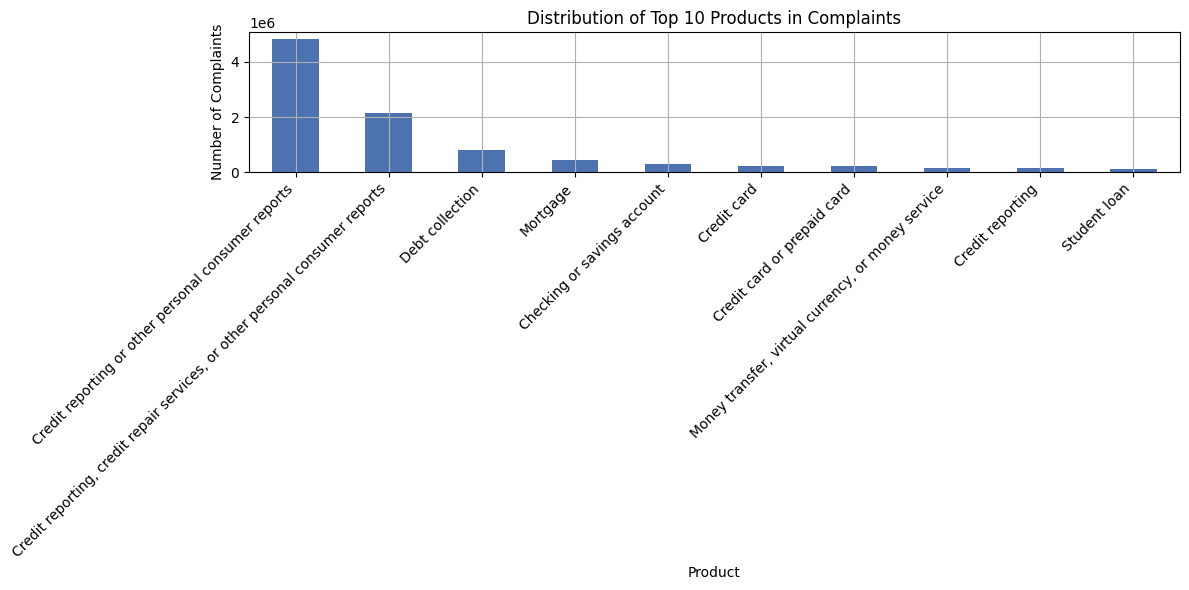


Target Product Categories:

Credit Cards:
  - Credit card: 226,686 complaints (2.4%)
  - Credit card or prepaid card: 206,369 complaints (2.1%)

Personal Loans:
  - Personal loan: 0 complaints (0.0%)
  - Consumer loan: 0 complaints (0.0%)
  - Payday loan: 5,541 complaints (0.1%)

Buy Now, Pay Later (BNPL):
  - Buy now, pay later: 0 complaints (0.0%)

Savings Accounts:
  - Checking or savings account: 291,178 complaints (3.0%)
  - Bank account or service: 86,205 complaints (0.9%)

Money Transfers:
  - Money transfer, virtual currency, or money service: 145,066 complaints (1.5%)

Filtering products...
Looking for the following categories:

Credit Cards:
  - Credit card
  - Credit card or prepaid card

Personal Loans:
  - Personal loan
  - Consumer loan
  - Payday loan

Buy Now, Pay Later (BNPL):
  - Buy now, pay later

Savings Accounts:
  - Checking or savings account
  - Bank account or service

Money Transfers:
  - Money transfer, virtual currency, or money service

Matched products d

<Figure size 1000x500 with 0 Axes>

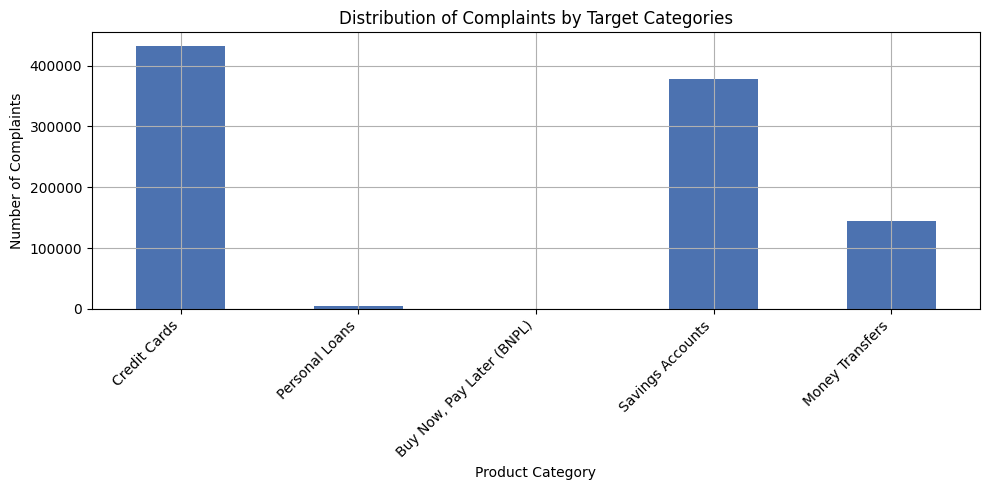

In [31]:
# Analyze overall product distribution
print("Overall Product Distribution:")
print("-" * 50)

# Get product distribution
product_counts = df['Product'].value_counts()
print("\nTop 10 products by number of complaints:")
print(product_counts.head(10))

# Plot distribution for top 10 products
plt.figure(figsize=(12, 6))
product_counts.head(10).plot(kind='bar')
plt.title('Distribution of Top 10 Products in Complaints')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show our target product categories
print("\nTarget Product Categories:")
for category, variations in cfg.PRODUCT_MAPPING.items():
    print(f"\n{category}:")
    for var in variations:
        count = product_counts.get(var, 0)
        percentage = (count / len(df)) * 100
        print(f"  - {var}: {count:,} complaints ({percentage:.1f}%)")

# Filter for our target products
df_filtered = filter_products(df)

# Visualize filtered products by our high-level categories
plt.figure(figsize=(10, 5))
category_counts = {}
for category, variations in cfg.PRODUCT_MAPPING.items():
    category_counts[category] = df_filtered[df_filtered['Product'].isin(variations)]['Product'].count()

# Plot the high-level categories
plt.figure(figsize=(10, 5))
pd.Series(category_counts).plot(kind='bar')
plt.title('Distribution of Complaints by Target Categories')
plt.xlabel('Product Category')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [32]:
# Process the complaints data
df_processed = preprocess_complaints(df_filtered)

print("\nSample of Cleaned Narratives:")
print("-" * 50)
sample_narratives = df_processed[['Consumer complaint narrative', 'clean_narrative']].head(3)
for i, row in sample_narratives.iterrows():
    print(f"\nOriginal: {row['Consumer complaint narrative'][:200]}...")
    print(f"\nCleaned: {row['clean_narrative'][:200]}...")
print("-" * 50)



Available columns in DataFrame:
['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']
Selected 11 columns for processing

Cleaning complaint narratives...
Retained 443,472 complaints with non-empty narratives

Sample of Cleaned Narratives:
--------------------------------------------------

Original: A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unaut...

Cleaned: A REDACTED REDACTED card was opened under my name by a fraudster. I received a notice from REDACTED that an account was just opened under my name. I reached out to REDACTED REDACTED to state that this...

Origin

In [33]:
# Display sample narratives
print("\nSample of Cleaned Narratives:")
print("-" * 50)

# Make sure we're using the correct column names
narrative_col = 'Consumer complaint narrative'
sample_narratives = df_processed[[narrative_col, 'clean_narrative']].head(3)

# Display samples
for i, row in sample_narratives.iterrows():
    print(f"\nOriginal: {row[narrative_col][:200]}...")
    print(f"\nCleaned: {row['clean_narrative'][:200]}...")
print("-" * 50)



Sample of Cleaned Narratives:
--------------------------------------------------

Original: A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unaut...

Cleaned: A REDACTED REDACTED card was opened under my name by a fraudster. I received a notice from REDACTED that an account was just opened under my name. I reached out to REDACTED REDACTED to state that this...

Original: I made the mistake of using my wellsfargo debit card to depsit funds Into XXXXXXXX ATM machine outside their branch. 

I went into the branch and was told they couldn't help and had to phone the custo...

Cleaned: I made the mistake of using my wellsfargo debit card to depsit funds Into REDACTED ATM machine outside their branch. I went into the branch and was told they couldn't help and had to phone the custome...

Original: Dear CFPB, I have a secured credit card with citi

Narrative Text Analysis:
--------------------------------------------------

Narrative Length Statistics:
count   961045.000
mean       526.835
std       1025.973
min          0.000
25%          0.000
50%          0.000
75%        709.000
max      32785.000
Name: narrative_length, dtype: float64


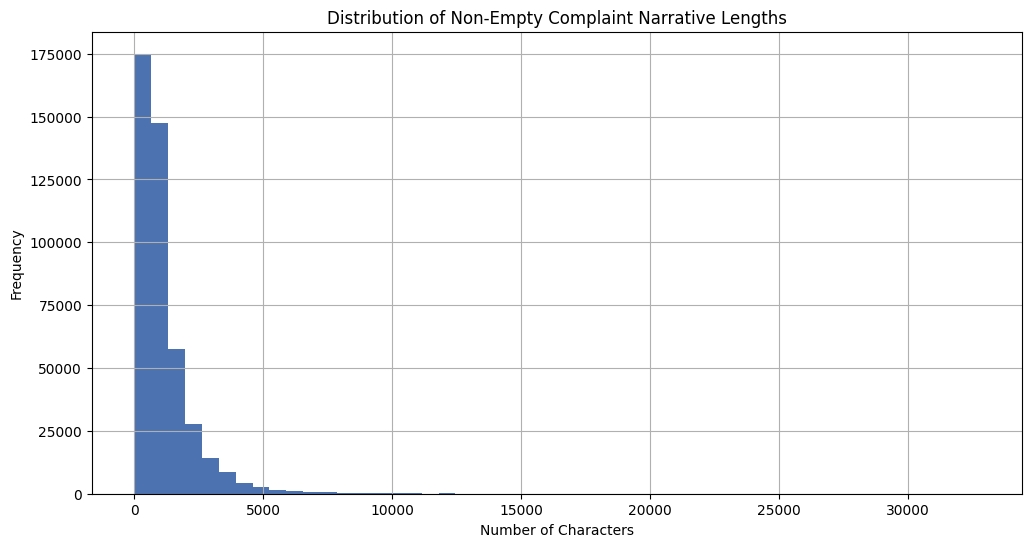


Narrative Statistics:
Total complaints: 961,045
Complaints with narratives: 443,472 (46.1%)
Complaints without narratives: 517,573 (53.9%)

Sample Narratives:
--------------------------------------------------

Narrative 1 (Length: 488 characters):
A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unaut...

Narrative 2 (Length: 555 characters):
I made the mistake of using my wellsfargo debit card to depsit funds Into XXXXXXXX ATM machine outside their branch. 

I went into the branch and was told they couldn't help and had to phone the custo...

Narrative 3 (Length: 806 characters):
Dear CFPB, I have a secured credit card with citibank which is changed to unsecured card and I have been calling n waitting for the check release the secured amount {$2500.00} for rhat credit card. Th...

Average Narrative Length by Product Category:
-------------

In [34]:
# Analyze narrative text
print("Narrative Text Analysis:")
print("-" * 50)

# Get the narrative column name
narrative_col = 'Consumer complaint narrative'

# Calculate narrative lengths
df_filtered['narrative_length'] = df_filtered[narrative_col].fillna('').str.len()

# Basic statistics of narrative length
print("\nNarrative Length Statistics:")
print(df_filtered['narrative_length'].describe())

# Plot distribution of narrative lengths (excluding empty narratives)
plt.figure(figsize=(12, 6))
non_empty_lengths = df_filtered[df_filtered['narrative_length'] > 0]['narrative_length']
plt.hist(non_empty_lengths, bins=50)
plt.title('Distribution of Non-Empty Complaint Narrative Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Count complaints with and without narratives
has_narrative = df_filtered[narrative_col].notna().sum()
total_complaints = len(df_filtered)
print(f"\nNarrative Statistics:")
print(f"Total complaints: {total_complaints:,}")
print(f"Complaints with narratives: {has_narrative:,} ({has_narrative/total_complaints:.1%})")
print(f"Complaints without narratives: {total_complaints-has_narrative:,} ({(total_complaints-has_narrative)/total_complaints:.1%})")

# Show sample narratives
print("\nSample Narratives:")
print("-" * 50)
sample_narratives = df_filtered[df_filtered[narrative_col].notna()][narrative_col].head(3)
for i, narrative in enumerate(sample_narratives, 1):
    print(f"\nNarrative {i} (Length: {len(narrative)} characters):")
    print(narrative[:200] + "..." if len(narrative) > 200 else narrative)

# Additional analysis: Narrative length by product category
print("\nAverage Narrative Length by Product Category:")
print("-" * 50)
avg_lengths = df_filtered.groupby('Product')['narrative_length'].agg(['mean', 'count']).round(2)
avg_lengths = avg_lengths[avg_lengths['count'] > 0].sort_values('mean', ascending=False)
print(avg_lengths)


In [35]:
# Import the save_processed_data function
from src.data.preprocessing import save_processed_data

# Process the data
print("Processing complaints data...")
df_processed = preprocess_complaints(df_filtered)

# Display sample of cleaned narratives
print("\nSample of Cleaned Narratives:")
print("-" * 50)
narrative_col = 'Consumer complaint narrative'  # Use the correct column name
sample_narratives = df_processed[[narrative_col, 'clean_narrative']].head(3)
for i, row in sample_narratives.iterrows():
    print(f"\nOriginal: {row[narrative_col][:200]}...")
    print(f"Cleaned:  {row['clean_narrative'][:200]}...")

# Save the processed data
save_processed_data(df_processed)

print("\nProcessing Summary:")
print("-" * 50)
print(f"Original number of complaints: {len(df):,}")
print(f"Filtered complaints: {len(df_filtered):,}")
print(f"Final processed complaints: {len(df_processed):,}")


Processing complaints data...

Available columns in DataFrame:
['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narrative_length']
Selected 11 columns for processing

Cleaning complaint narratives...
Retained 443,472 complaints with non-empty narratives

Sample of Cleaned Narratives:
--------------------------------------------------

Original: A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unaut...
Cleaned:  A REDACTED REDACTED card was opened under my name by a fraudster. I received a notice from REDACTED that an account was just opened under my name. I reached out 

Analysis of Processed Data:
--------------------------------------------------

Top Issues by Product:

Credit card:
Issue
Problem with a purchase shown on your statement                    14338
Problem with a company's investigation into an existing problem     7362
Getting a credit card                                               7253
Name: count, dtype: int64

Credit card or prepaid card:
Issue
Problem with a purchase shown on your statement    26159
Other features, terms, or problems                 12755
Fees or interest                                   11340
Name: count, dtype: int64

Personal loan:
Series([], Name: count, dtype: int64)

Consumer loan:
Series([], Name: count, dtype: int64)

Payday loan:
Issue
Charged fees or interest I didn't expect    752
Can't contact lender                        339
Received a loan I didn't apply for          202
Name: count, dtype: int64

Buy now, pay later:
Series([], Name: count, dtype: int64)

Checking or savings account:
Issue
Managi

<Figure size 1500x600 with 0 Axes>

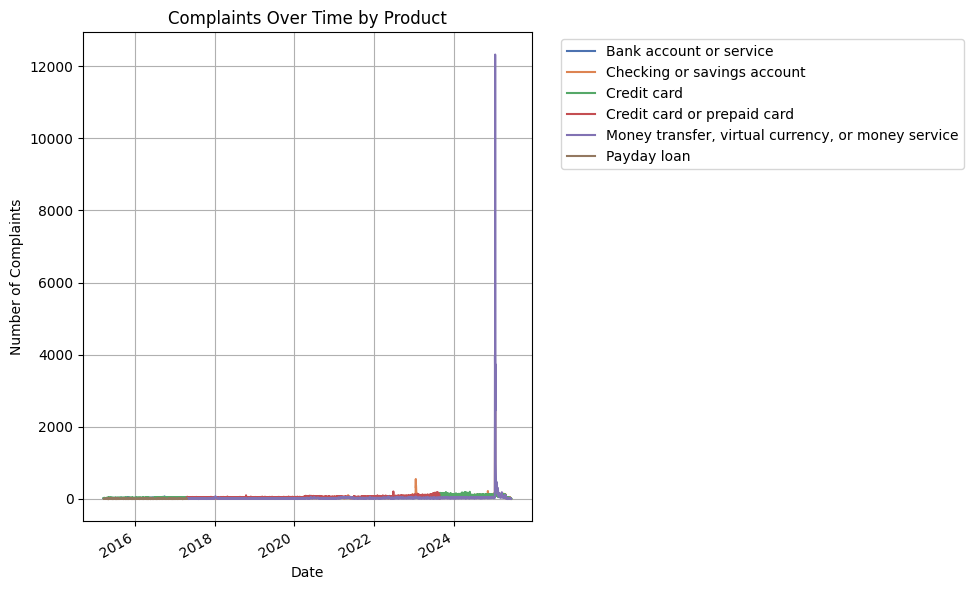


Company Response Analysis:
Company public response
Company has responded to the consumer and the CFPB and chooses not to provide a public response    156857
Company believes it acted appropriately as authorized by contract or law                            18933
Company chooses not to provide a public response                                                     5496
Company believes complaint is the result of an isolated error                                         509
Company believes complaint represents an opportunity for improvement to better serve consumers        440
                                                                                                    ...  
Company believes the complaint provided an opportunity to answer consumer's questions                 322
Company believes the complaint is the result of a misunderstanding                                    269
Company disputes the facts presented in the complaint                                               

In [36]:
# Import necessary constants
from config.config import PRODUCT_CATEGORIES

# Additional analysis of processed data
print("Analysis of Processed Data:")
print("-" * 50)

# Issues by product
print("\nTop Issues by Product:")
for product in PRODUCT_CATEGORIES:
    print(f"\n{product}:")
    print(df_processed[df_processed['Product'] == product]['Issue'].value_counts().head(3))

# Time series analysis
plt.figure(figsize=(15, 6))
df_processed.groupby(['Date received', 'Product']).size().unstack().plot()
plt.title('Complaints Over Time by Product')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Company response analysis
print("\nCompany Response Analysis:")
response_counts = df_processed['Company public response'].value_counts()
print(response_counts)

# Geographic distribution
print("\nTop 10 States by Number of Complaints:")
print(df_processed['State'].value_counts().head(10))


Product Distribution Analysis
--------------------------------------------------

Product Distribution:
Checking or savings account: 140,319 complaints (31.6%)
Credit card or prepaid card: 108,667 complaints (24.5%)
Money transfer, virtual currency, or money service: 97,188 complaints (21.9%)
Credit card: 80,667 complaints (18.2%)
Bank account or service: 14,885 complaints (3.4%)
Payday loan: 1,746 complaints (0.4%)


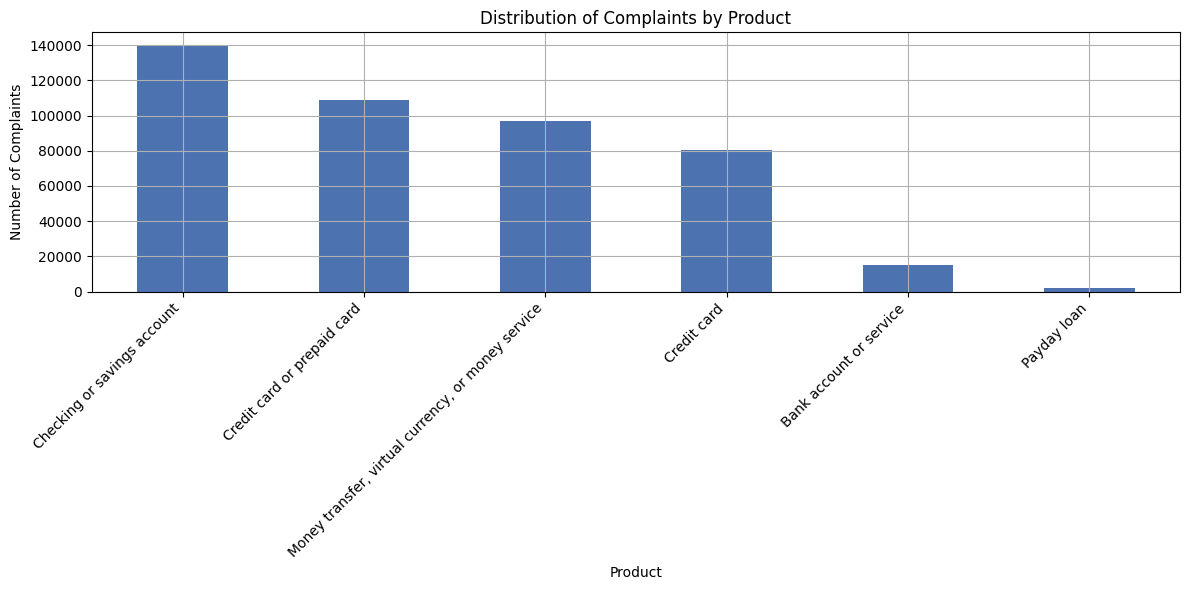


Top Sub-products by Product Category:
--------------------------------------------------

Credit card:
  - General-purpose credit card or charge card: 53,669 (66.5%)
  - Store credit card: 8,161 (10.1%)

Checking or savings account:
  - Checking account: 115,568 (82.4%)
  - Savings account: 11,359 (8.1%)
  - Other banking product or service: 11,056 (7.9%)
  - CD (Certificate of Deposit): 2,301 (1.6%)

Money transfer, virtual currency, or money service:
  - Domestic (US) money transfer: 56,316 (57.9%)
  - Mobile or digital wallet: 21,409 (22.0%)
  - Virtual currency: 9,637 (9.9%)
  - International money transfer: 5,714 (5.9%)
  - Check cashing service: 1,048 (1.1%)

Credit card or prepaid card:
  - General-purpose credit card or charge card: 83,526 (76.9%)
  - Store credit card: 15,502 (14.3%)
  - General-purpose prepaid card: 4,856 (4.5%)
  - Government benefit card: 3,661 (3.4%)
  - Gift card: 618 (0.6%)

Bank account or service:
  - Checking account: 10,113 (67.9%)
  - Other bank pr

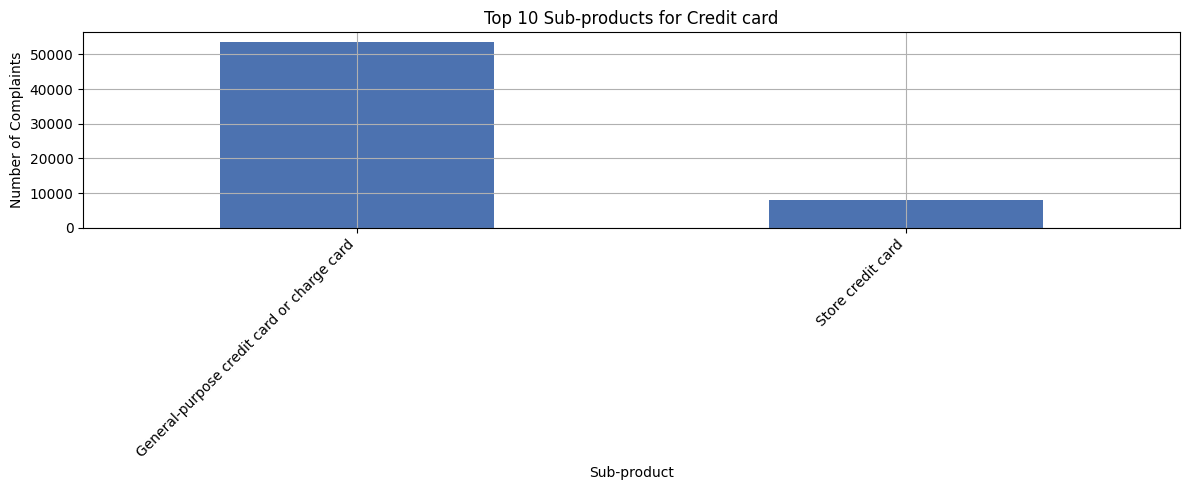

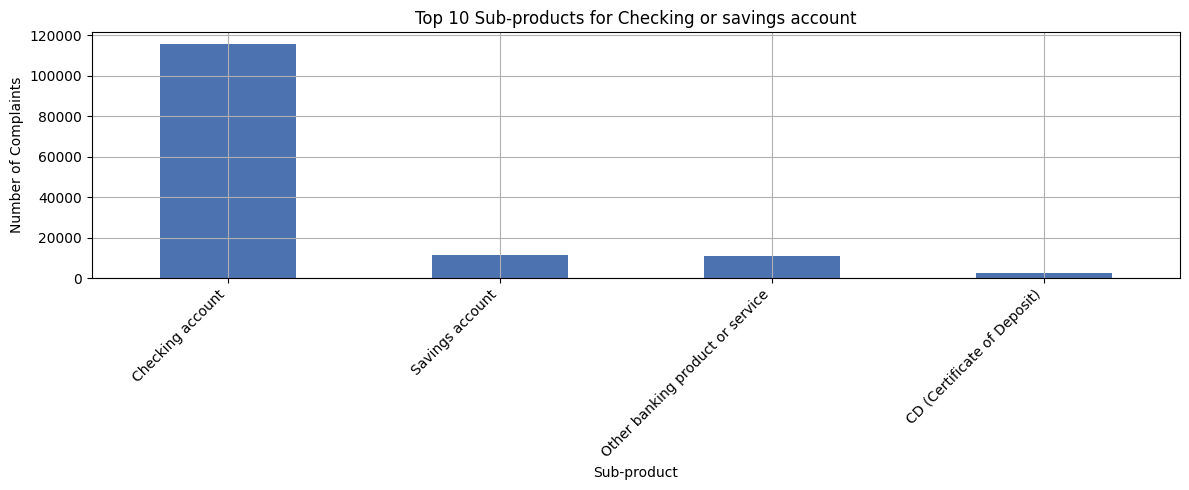

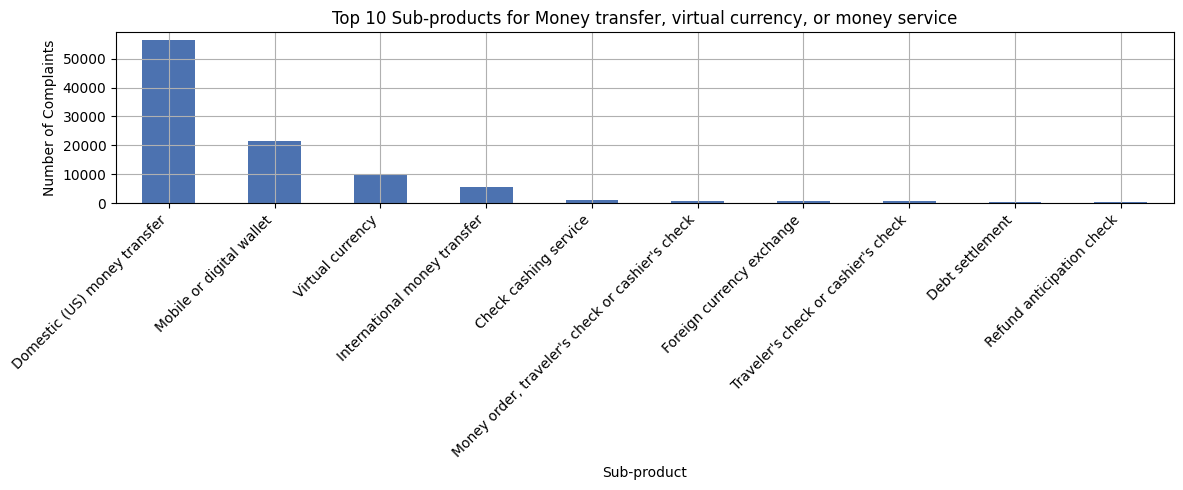

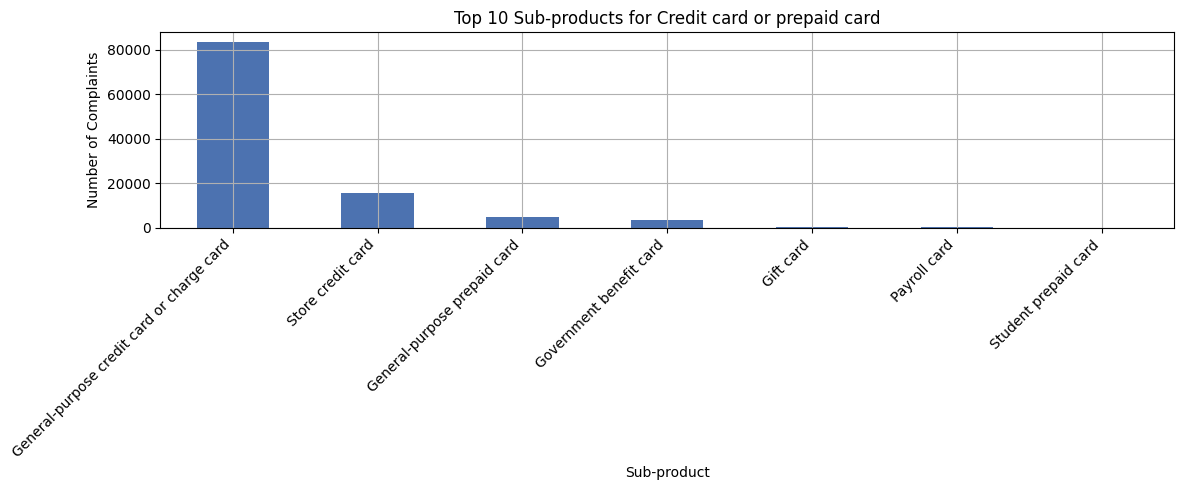

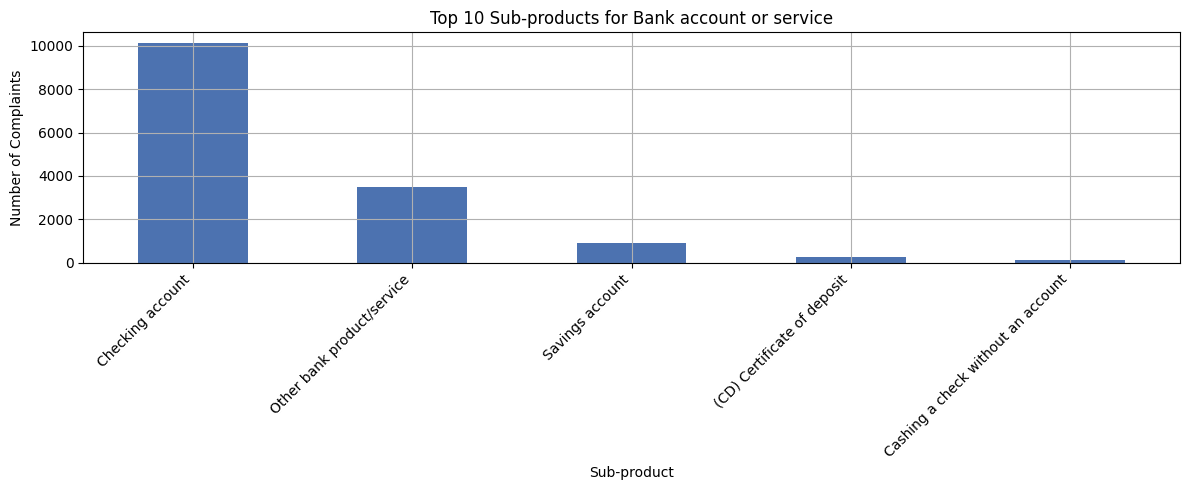

IndexError: index 0 is out of bounds for axis 0 with size 0

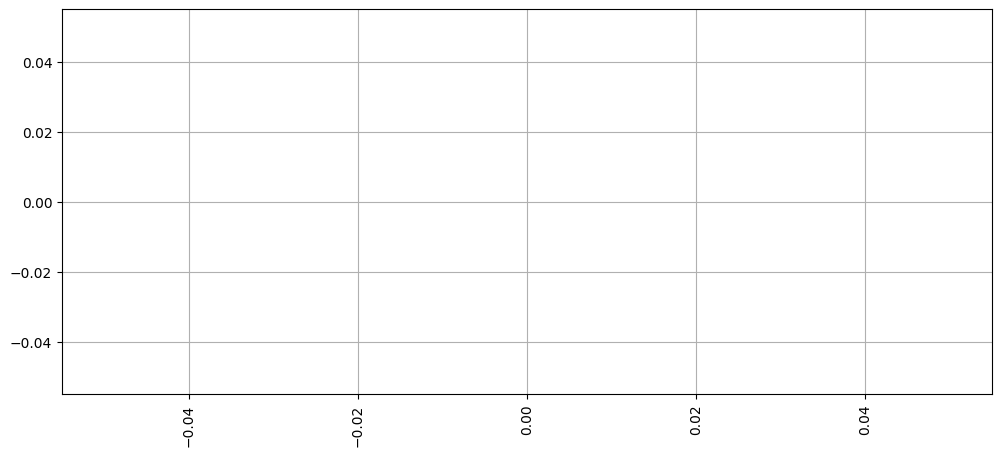

In [37]:
# Product Distribution Analysis
print("Product Distribution Analysis")
print("-" * 50)

# Overall product distribution
product_dist = df_processed['Product'].value_counts()
product_pct = df_processed['Product'].value_counts(normalize=True) * 100

print("\nProduct Distribution:")
for product, count in product_dist.items():
    pct = product_pct[product]
    print(f"{product}: {count:,} complaints ({pct:.1f}%)")

# Visualize product distribution
plt.figure(figsize=(12, 6))
product_dist.plot(kind='bar')
plt.title('Distribution of Complaints by Product')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sub-product analysis
print("\nTop Sub-products by Product Category:")
print("-" * 50)
for product in df_processed['Product'].unique():
    print(f"\n{product}:")
    subproduct_dist = df_processed[df_processed['Product'] == product]['Sub-product'].value_counts().head(5)
    if len(subproduct_dist) > 0:
        for subproduct, count in subproduct_dist.items():
            pct = (count / len(df_processed[df_processed['Product'] == product])) * 100
            print(f"  - {subproduct}: {count:,} ({pct:.1f}%)")
    else:
        print("  No sub-products found")

# Visualize sub-product distribution for each product
for product in df_processed['Product'].unique():
    subproduct_dist = df_processed[df_processed['Product'] == product]['Sub-product'].value_counts().head(10)
    
    # Only create plot if there are sub-products
    if len(subproduct_dist) > 0:
        plt.figure(figsize=(12, 5))
        subproduct_dist.plot(kind='bar')
        plt.title(f'Top 10 Sub-products for {product}')
        plt.xlabel('Sub-product')
        plt.ylabel('Number of Complaints')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\nNo sub-products to visualize for {product}")


In [ ]:
### 2.2 Issue Analysis

print("Issue Distribution Analysis")
print("-" * 50)

# Overall issue distribution
issue_dist = df_processed['Issue'].value_counts()
issue_pct = df_processed['Issue'].value_counts(normalize=True) * 100

print("\nTop 10 Issues Overall:")
for issue, count in issue_dist.head(10).items():
    pct = issue_pct[issue]
    print(f"{issue}: {count:,} complaints ({pct:.1f}%)")

# Visualize overall issue distribution
plt.figure(figsize=(14, 6))
issue_dist.head(10).plot(kind='bar')
plt.title('Top 10 Issues Overall')
plt.xlabel('Issue')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Issue distribution by product
print("\nTop Issues by Product:")
print("-" * 50)
for product in df_processed['Product'].unique():
    print(f"\n{product}:")
    product_issues = df_processed[df_processed['Product'] == product]['Issue'].value_counts().head(5)
    for issue, count in product_issues.items():
        pct = (count / len(df_processed[df_processed['Product'] == product])) * 100
        print(f"  - {issue}: {count:,} ({pct:.1f}%)")
    
    # Visualize issues for this product
    plt.figure(figsize=(12, 5))
    product_issues.plot(kind='bar')
    plt.title(f'Top Issues for {product}')
    plt.xlabel('Issue')
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Create a heatmap of Products vs Issues
pivot_table = pd.crosstab(df_processed['Product'], df_processed['Issue'])
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='d', cbar_kws={'label': 'Number of Complaints'})
plt.title('Heatmap of Products vs Issues')
plt.xlabel('Issue')
plt.ylabel('Product')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
### 2.3 Temporal Analysis

print("Temporal Analysis")
print("-" * 50)

# Add datetime components
df_processed['Year'] = df_processed['Date received'].dt.year
df_processed['Month'] = df_processed['Date received'].dt.month
df_processed['Day'] = df_processed['Date received'].dt.day
df_processed['Weekday'] = df_processed['Date received'].dt.day_name()

# Complaints over time
monthly_complaints = df_processed.groupby([df_processed['Date received'].dt.to_period('M')]).size()

plt.figure(figsize=(15, 6))
monthly_complaints.plot(kind='line', marker='o')
plt.title('Number of Complaints Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.grid(True)
plt.tight_layout()
plt.show()

# Complaints by year
yearly_complaints = df_processed.groupby('Year').size()
print("\nComplaints by Year:")
for year, count in yearly_complaints.items():
    pct = (count / len(df_processed)) * 100
    print(f"{year}: {count:,} complaints ({pct:.1f}%)")

# Complaints by month
monthly_avg = df_processed.groupby('Month').size().mean()
monthly_pattern = df_processed.groupby('Month').size()
print("\nMonthly Pattern (average across all years):")
for month, count in monthly_pattern.items():
    pct = (count / len(df_processed)) * 100
    vs_avg = ((count - monthly_avg) / monthly_avg) * 100
    print(f"Month {month}: {count:,} complaints ({pct:.1f}%), {vs_avg:+.1f}% vs average")

# Complaints by day of week
weekday_pattern = df_processed.groupby('Weekday').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(10, 5))
weekday_pattern.plot(kind='bar')
plt.title('Complaints by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Complaints')
plt.tight_layout()
plt.show()

# Time series by product
plt.figure(figsize=(15, 8))
for product in df_processed['Product'].unique():
    product_ts = df_processed[df_processed['Product'] == product].groupby([df_processed['Date received'].dt.to_period('M')]).size()
    plt.plot(range(len(product_ts)), product_ts, label=product, marker='o')

plt.title('Complaints Over Time by Product')
plt.xlabel('Months (from start)')
plt.ylabel('Number of Complaints')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
### 2.4 Geographic and Response Analysis

print("Geographic and Response Analysis")
print("-" * 50)

# State distribution
state_dist = df_processed['State'].value_counts()
state_pct = df_processed['State'].value_counts(normalize=True) * 100

print("\nTop 10 States by Number of Complaints:")
for state, count in state_dist.head(10).items():
    pct = state_pct[state]
    print(f"{state}: {count:,} complaints ({pct:.1f}%)")

# Visualize state distribution
plt.figure(figsize=(15, 6))
state_dist.head(20).plot(kind='bar')
plt.title('Top 20 States by Number of Complaints')
plt.xlabel('State')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Company response analysis
response_dist = df_processed['Company public response'].value_counts()
response_pct = df_processed['Company public response'].value_counts(normalize=True) * 100

print("\nCompany Response Distribution:")
for response, count in response_dist.items():
    pct = response_pct[response]
    print(f"{response}: {count:,} responses ({pct:.1f}%)")

# Visualize response distribution
plt.figure(figsize=(10, 6))
response_dist.plot(kind='bar')
plt.title('Distribution of Company Public Responses')
plt.xlabel('Response Type')
plt.ylabel('Number of Responses')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Response analysis by product
print("\nResponse Distribution by Product:")
print("-" * 50)
response_by_product = pd.crosstab(df_processed['Product'], df_processed['Company public response'], normalize='index') * 100
print(response_by_product.round(2))

# Visualize response distribution by product
plt.figure(figsize=(15, 8))
sns.heatmap(response_by_product, cmap='YlOrRd', annot=True, fmt='.1f', cbar_kws={'label': 'Percentage of Complaints'})
plt.title('Response Distribution by Product (%)')
plt.xlabel('Company Response')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary Statistics:")
print("-" * 50)
print(f"Total number of complaints analyzed: {len(df_processed):,}")
print(f"Number of unique products: {df_processed['Product'].nunique()}")
print(f"Number of unique sub-products: {df_processed['Sub-product'].nunique()}")
print(f"Number of unique issues: {df_processed['Issue'].nunique()}")
print(f"Number of unique companies: {df_processed['Company'].nunique()}")
print(f"Number of states represented: {df_processed['State'].nunique()}")
print(f"Date range: {df_processed['Date received'].min().date()} to {df_processed['Date received'].max().date()}")
